# Q. 41-50


In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

## Q.41-43. Canny edge detector
Cannyの一連の処理, 簡潔さ第一なので途中の処理は特に実装しない。Q43の結果がおかしいような。

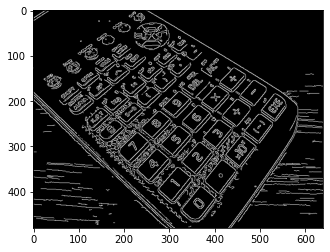

In [3]:
gimg = cv2.imread('Calc.jpg', cv2.IMREAD_GRAYSCALE)
dst = cv2.Canny(gimg, 100, 200,apertureSize=3)
plt.imshow(dst, cmap='gray')

## Q. 44-45 Hough 変換で線検出
standardなHough変換で線検出を行う場合はHoughLinesを使う。投票空間への閾値が設定可能。ここでは80。
linesの出力はrho, thetaなのであとで画像空間での2点(Lineの終端点)に戻す必要がある。

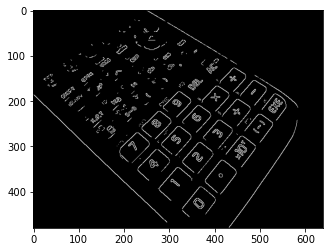

In [32]:
import numpy as np
gimg = cv2.imread('Calc.jpg', cv2.IMREAD_GRAYSCALE)
edge = cv2.Canny(gimg, 500, 600, apertureSize=3, )
plt.imshow(edge, cmap='gray')
lines = cv2.HoughLines(edge, 1, np.pi/180.0,  80)
dst = cv2.cvtColor(edge, cv2.COLOR_GRAY2BGR)


linesがNoneではない前提。
OpenCVのサンプルだとa, bに1000を乗算してるが(この例では300)，要は線が画像をはみ出すような座標を取っているだけなので，それぞれ画像高さと幅を乗算するだけでも良いが，4Kのような場合はそれなりの大きさにする必要があるので，とりあえずデカい数字にしておけば問題無い。

(-308, -112) (123, 304)
(223, 566) (600, 100)
(155, 532) (549, 79)
(132, 522) (533, 76)
(343, 607) (688, 115)
(-314, -102) (124, 306)
(-190, -265) (323, 43)
(277, 585) (638, 105)
(28, 461) (460, 44)
(84, 498) (501, 66)
(197, 556) (582, 97)
(93, 497) (502, 58)
(72, 487) (489, 55)
(-259, -157) (200, 228)
(334, 613) (686, 128)
(-267, -148) (192, 237)
(-303, -120) (120, 303)
(144, 534) (546, 88)
(-237, -183) (235, 186)
(63, 487) (487, 63)
(-295, -120) (150, 280)
(-215, -214) (270, 138)
(-223, -204) (268, 140)
(234, 563) (603, 91)
(-301, -122) (122, 301)
(121, 523) (530, 84)
(-293, -114) (172, 263)
(365, 595) (692, 92)
(77, 501) (501, 77)
(-182, -274) (326, 43)
(-312, -105) (126, 304)
(324, 620) (686, 141)


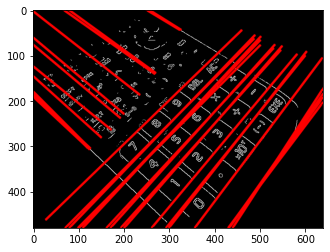

In [33]:
for l in lines:
    rho = l[0][0]
    theta = l[0][1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    pt1 = (np.int(x0 + 300 *(- b)),np.int( y0+ 300 * a))
    pt2 = (np.int(x0 - 300 * (- b)),np.int( y0 - 300 *a))
    print(pt1, pt2)
    cv2.line(dst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    

おまけでHough変換の確率的線抽出。
OpenCVだとHoughLinePを使う。HoughLinesPの返り値は頂点のペアなのでそのまま線を引けば良い。

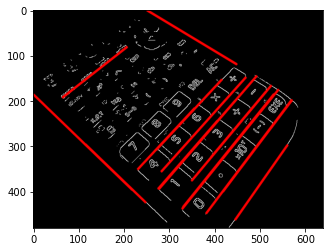

In [44]:
lines = cv2.HoughLinesP(edge, 1, np.pi/180.0, 50, minLineLength=130, maxLineGap=20)
dst = cv2.cvtColor(edge, cv2.COLOR_GRAY2BGR)
for l in lines:
    pt1 = (l[0][0], l[0][1])
    pt2 = (l[0][2], l[0][3])
    cv2.line(dst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))


## Q. 47. 膨張処理 (Morphological Processing)
structuring element(SE)の話が無いと雑な話になる。Morphological ProcessingはSEの形状によって処理結果が異なる。SEは施したい処理に応じて形状を決定する。
膨張は原画像とStructuring elementのHit演算で，OpenCVの関数dilateへ引数kernelとして与える。デフォルトでは3x3のSquareだが，わかりやすくするために縦長のRectangleにしてみる。
(getStructuringElementではMORPH_RECT, MORPH_CROSS, MORPH_ELLIPSEが用意されている)


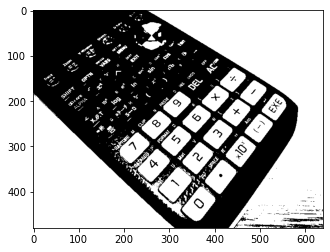

In [46]:
gimg = cv2.imread('Calc.jpg', cv2.IMREAD_GRAYSCALE)
ret, bimg = cv2.threshold(gimg, -1, 255, cv2.THRESH_OTSU)
plt.imshow(bimg, cmap='gray')

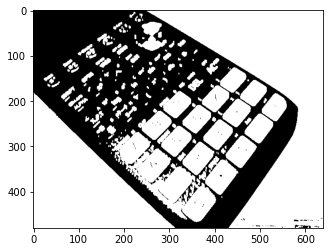

In [47]:
SE = cv2.getStructuringElement(cv2.MORPH_RECT, (2,4))
dst = cv2.dilate(bimg, kernel=SE)
plt.imshow(dst, cmap='gray')

SEをCrossにした場合。(縦横方向に膨張させるので擦れた文字を復元するのに使う)
文字を埋めたいので画像は反転させて処理

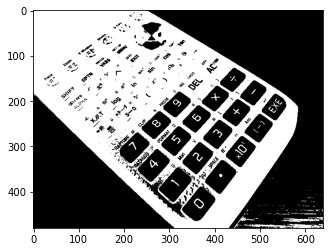

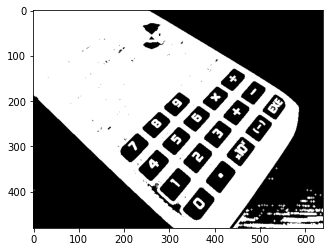

In [52]:
SEcross = cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))
plt.imshow(255-bimg, cmap='gray')
dstcross = cv2.dilate(255-bimg, kernel = SEcross)
plt.figure()
plt.imshow(dstcross, cmap='gray')

## Q.48. 収縮処理 (Morphological Processing)
erosionはSEとのFit演算と言える。ここでは横長のRectangleをSEにする。

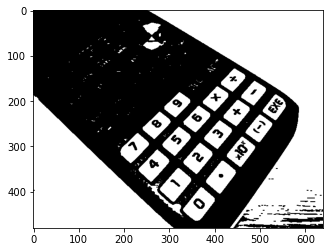

In [54]:
SE2 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,2))
dst2 = cv2.erode(bimg, kernel = SE2)
plt.imshow(dst2, cmap='gray')

## Q. 49. Opening処理
収縮処理をN回，膨張処理をN回のように，同じ回数施す。収縮させることで，くっついてしまっているBlob(塊)を分離する，細かいノイズを除去する効果がある。OpenCVではdilate, erodeのどちらも繰り返し回数を指定できる。ここではSEは3x3のCircleを使う。
※ノイズは除去できているが最適化しないと必要な情報も削れてしまう

※画像は[ここ](https://commons.wikimedia.org/wiki/File:Fingerprint_(PSF).png)から

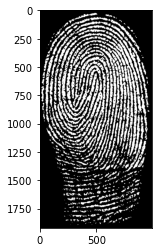

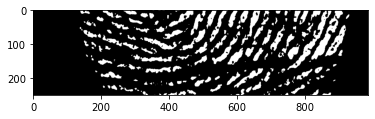

In [56]:
gimg = cv2.imread('Fingerprint_(PSF).png', cv2.IMREAD_GRAYSCALE)
ret, bimg = cv2.threshold(gimg, -1, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
plt.imshow(bimg, cmap='gray')
plt.figure()
plt.imshow(bimg[1250:1500,:], cmap='gray')


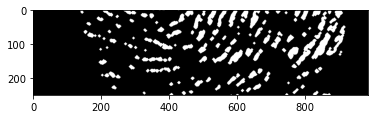

In [57]:
SEsq = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(3,3))
dst = cv2.erode(bimg, kernel = SEsq, iterations = 4)
dst = cv2.dilate(dst, kernel = SEsq,  iterations= 4)
plt.imshow(dst[1250:1500,:], cmap='gray')


## Q.50. Closing処理
Openingとは逆に膨張N回，収縮N回をする処理。膨張を先に行うのでBlobの欠損や穴を埋められるが，Opening同様に2値化でどの程度の前処理をするかで結果が大きく変わる。

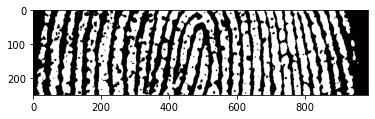

In [58]:
gimg = cv2.imread('Fingerprint_(PSF).png', cv2.IMREAD_GRAYSCALE)
ret, bimg = cv2.threshold(gimg, -1, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)
plt.imshow(bimg, cmap='gray')
plt.imshow(bimg[500:750,:], cmap='gray')


ここでは左右の稜線を繋げたくないので縦長のSEを使う

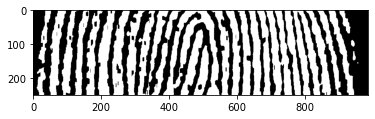

In [68]:
SEsq = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize=(1,3))
dst = cv2.dilate(bimg, kernel = SEsq,  iterations= 5)
dst = cv2.erode(dst, kernel = SEsq, iterations = 5)
plt.imshow(dst[500:750,:], cmap='gray')
